In [68]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
%matplotlib inline 
from skimage.io import imread
from skimage import color
from copy import copy
import cv2
from skimage.feature import canny
import LinOT
from scipy.optimize import fmin as simplex
from skimage.transform import hough_line, hough_line_peaks
import skimage.filters
import copy
from skimage.color import rgb2hsv, hsv2rgb 
import cv2
import numpy as np
from sklearn.cluster import KMeans

In [69]:
X = np.load("./dataset/X.npy", allow_pickle=True)
y = np.load("./dataset/y.npy", allow_pickle=False)
def reconstruct_label(label): 
    #max_dist = label[-1]
    return np.array([(label[i], label[i+1]) for i in range(0, len(label), 2)])#*max_dist


In [143]:
def perspective_transform(image, corners):
    # Define the dimensions of the output image
    width = max(np.linalg.norm(corners[0] - corners[1]), np.linalg.norm(corners[2] - corners[3]))
    height = max(np.linalg.norm(corners[0] - corners[3]), np.linalg.norm(corners[1] - corners[2]))
    output_size = np.array([width, height], dtype=np.int32)

    # Define the coordinates of the paper corners in the output image
    paper_corners = np.array([[0, 0], [output_size[0] - 1, 0], [output_size[0] - 1, output_size[1] - 1], [0, output_size[1] - 1]], dtype=np.float32)

    # Compute the perspective transform matrix
    transform_matrix = cv2.getPerspectiveTransform(corners, paper_corners)

    # Apply the perspective transformation to the image
    warped_image = cv2.warpPerspective(image, transform_matrix, tuple(output_size))

    return warped_image

In [144]:
def filter_(face):
    mask = np.zeros(face.shape[:2])
    width = mask.shape[0]
    height = mask.shape[1]
    hpoints = [(i/3+1/6)*height for i in range(3)]
    wpoints = [(i/3+1/6)*width for i in range(3)]
    points = np.array([(x,y) for x in wpoints for y in hpoints])
    r = .95*((height/3 -height/6 )+ (width/3 -width/6 ))/2
    for x in range(width):
        for y in range(height):
            for i in range(9):
                if np.sqrt((x-points[i,0])**2+(y-points[i,1])**2)<r:
                    mask[x,y] = 1
    filtered_img = copy.copy(face)
    for i in range(3):
        filtered_img[:,:,i]= filtered_img[:,:,i]*mask
    return filtered_img

In [261]:
i = np.random.randint(0,497) #6
#i = 6
image = X[i]
label = reconstruct_label(y[i])
face1 = perspective_transform(image, np.array(label[:4], dtype=np.float32))
face2 = perspective_transform(image, np.array(label[[0, 3, 4, 5]], dtype=np.float32))
face3 = perspective_transform(image, np.array(label[[0, 1, 6, 5]], dtype=np.float32))

In [262]:
def train_kmeans(faces, number_of_colors):
    # Flatten face images and convert to HSV
    all_faces = []
    for _ in range(3):
        all_faces.append(cv2.cvtColor(filter_(faces[0]), cv2.COLOR_RGB2HSV).reshape((-1, 3)))
        all_faces.append(cv2.cvtColor(filter_(faces[1]), cv2.COLOR_RGB2HSV).reshape((-1, 3)))
        all_faces.append(cv2.cvtColor(filter_(faces[2]), cv2.COLOR_RGB2HSV).reshape((-1, 3)))
    # Concatenate face pixels
    all_face_pixels = np.concatenate([all_faces[0], all_faces[1], all_faces[2]], axis=0)
    kmeans = KMeans(n_clusters=number_of_colors)
    kmeans.fit(all_face_pixels)
    return kmeans

In [263]:
def extract_state(faces, number_of_colors):
    # Fit kmeans model
    kmeans = train_kmeans(faces, number_of_colors)
    labels = []
    images = []
    for j in range(3):
        image = faces[j]
        # Initialize label array
        label = np.zeros(9)
        # Find points of interest
        width = image.shape[0]
        height = image.shape[1]
        hpoints = [(i/3+1/6)*height for i in range(3)]
        wpoints = [(i/3+1/6)*width for i in range(3)]
        points = np.array([(x,y) for x in wpoints for y in hpoints])
        r = .95*((height/3 - height/6) + (width/3 - width/6))/2
        
        # Change image to HSV
        pixels = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) 
        for i in range(9):
            bucket = []
            mask = np.zeros(image.shape[:2])
            
            # Collect pixels within circle
            for x in range(width):
                for y in range(height):
                    if np.sqrt((x-points[i,0])**2 + (y-points[i,1])**2) < r:
                        bucket.append(pixels[x, y, :])
                        
            bucket = np.array(bucket)
            
            # Predict cluster for collected pixels
            predicted_colors = kmeans.predict(bucket)
            
            # Count occurrences of each cluster
            counts = np.bincount(predicted_colors)
            
            # Assign label to majority cluster
            label[i] = np.argmax(counts)
        
        # Reshape label array
        label = label.reshape((3, 3)).astype(np.uint8)
        
        # Convert image to HSV for color reduction
        pixels = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        pixels = pixels.reshape((-1, 3))
        predicted_colors = kmeans.predict(pixels)
        reduced_image = kmeans.cluster_centers_[predicted_colors]
        reduced_image = reduced_image.reshape(image.shape)
        
        # Convert reduced image back to RGB
        reduced_image_rgb = cv2.cvtColor(reduced_image.astype(np.uint8), cv2.COLOR_HSV2RGB)
        images.append(reduced_image_rgb)
        labels.append(label)
    # find the colors corresponding with label
    cluster_colors_hsv = kmeans.cluster_centers_
    cluster_colors_rgb = cv2.cvtColor(np.uint8([cluster_colors_hsv]), cv2.COLOR_HSV2RGB)
    return images, labels, cluster_colors_rgb[0]

In [280]:
i = np.random.randint(0,497) #6

image = X[i]
label = reconstruct_label(y[i])
face1 = perspective_transform(image, np.array(label[:4], dtype=np.float32))
face2 = perspective_transform(image, np.array(label[[0, 3, 4, 5]], dtype=np.float32))
face3 = perspective_transform(image, np.array(label[[0, 1, 6, 5]], dtype=np.float32))
faces = [face1,face2,face3]

In [285]:
num_colors = 4
images, labels, colors = extract_state(faces, num_colors)
state1, label1 = images[0], labels[0]
state2, label2 = images[1], labels[1]
state3, label3 = images[2], labels[2]

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


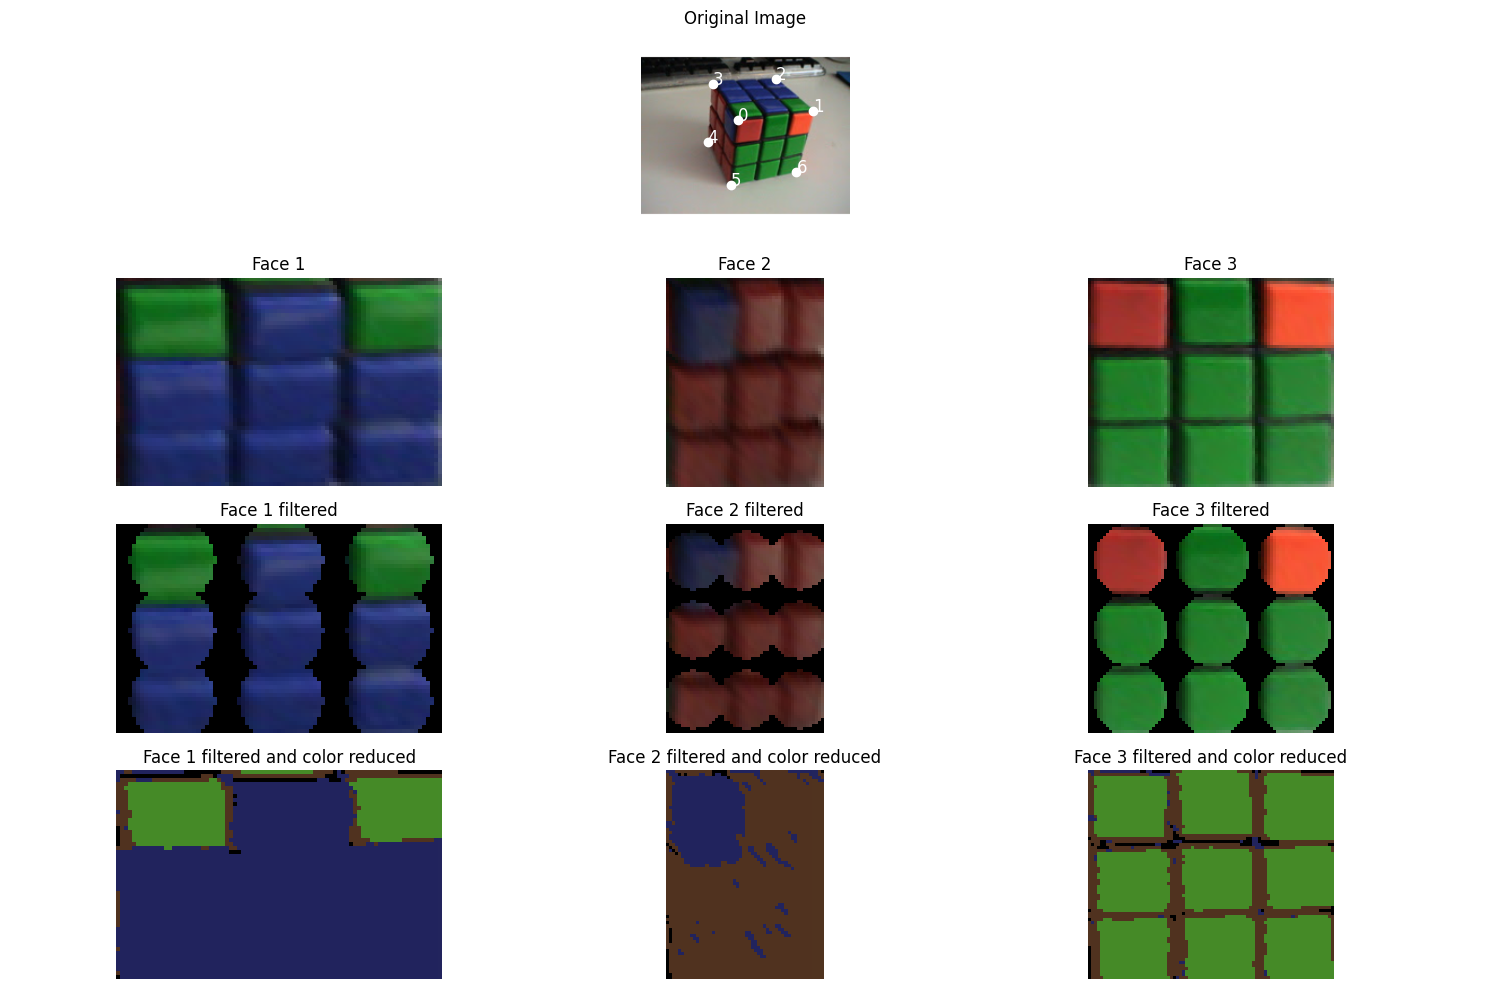

In [286]:

# Plotting
fig, axes = plt.subplots(4, 3, figsize=(15, 10))

# Original image and label
axes[0, 1].imshow(image, cmap='gray')
for i in range(7):
    axes[0, 1].scatter(label[i, 0], label[i, 1], color='w')
    axes[0, 1].text(label[i, 0], label[i, 1], str(i), fontsize=12, color='w')
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('off')
axes[0, 0].axis('off')
axes[0, 2].axis('off')

axes[1, 0].imshow(face1, cmap='gray')
axes[1, 0].set_title('Face 1')
axes[1, 0].axis('off')

axes[1, 1].imshow(face2, cmap='gray')
axes[1, 1].set_title('Face 2')
axes[1, 1].axis('off')

axes[1, 2].imshow(face3, cmap='gray')
axes[1, 2].set_title('Face 3')
axes[1, 2].axis('off')

axes[2, 0].imshow(filter_(face1), cmap='gray')
axes[2, 0].set_title('Face 1 filtered')
axes[2, 0].axis('off')

axes[2, 1].imshow(filter_(face2), cmap='gray')
axes[2, 1].set_title('Face 2 filtered')
axes[2, 1].axis('off')

axes[2, 2].imshow(filter_(face3), cmap='gray')
axes[2, 2].set_title('Face 3 filtered')
axes[2, 2].axis('off')


axes[3, 0].imshow(state1, cmap='gray')
axes[3, 0].set_title('Face 1 filtered and color reduced')
axes[3, 0].axis('off')


axes[3, 1].imshow(state2, cmap='gray')
axes[3, 1].set_title('Face 2 filtered and color reduced')
axes[3, 1].axis('off')


axes[3, 2].imshow(state3, cmap='gray')
axes[3, 2].set_title('Face 3 filtered and color reduced')
axes[3, 2].axis('off')
fig.tight_layout()
#plt.show()


In [287]:
def visualize_cube(labels, colors):
    visface1 = [(3,7,23,19),
                (19,23,39,35),
                (35,39,55,51),
                (7,11,27,23),
                (23,27,43,39),
                (39,43,59,55),
                (11,15,31,27),
                (27,31,47,43),
                (43,47,63,59)]
    visface2 = [(0,1,17,16),
                (16,17,33,32),
                (32,33,49,48),
                (1,2,18,17),
                (17,18,34,33),
                (33,34,50,49),
                (2,3,19,18),
                (18,19,35,34),
               (34,35,51,50)]
    visface3 = [
                (48,49,53,52),
                (52,53,57,56),
                (56,57,61,60),
                (49,50,54,53),
                (53,54,58,57),
                (57,58,62,61),
                (50,51,55,54),
                (54,55,59,58),
                (58,59,63,62)]
    points = [] 
    for i in range(4):
        for j in range(4):
            for k in range(4):
                points.append([i,j,k])
    points = np.array(points)
    visfaces = [visface3,visface1,visface2]
    visfaces = [visface1,visface2,visface3]
    fig = plt.figure(figsize=(12, 6))
    
    # Plot original image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image')
    
    # Plot 3D visualization
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    for i in range(3):
        visface = visfaces[i]
        label = labels[i].reshape(-1)
        for j in range(9):
            vertix = np.array([points[visface[j][k]] for k in range(4)])
            verts = [list(zip(vertix[:,0], vertix[:,1], vertix[:,2]))]
            parallelogram = Poly3DCollection(verts, alpha=0.5, facecolor=colors[label[j]]/255, linewidths=1, edgecolors='k')
            ax2.add_collection3d(parallelogram)
    ax2.set_title('Extracted state')
    ax2.set_xlim(-0,3)
    ax2.set_ylim(-0,3)
    ax2.set_zlim(-0,3)
    ax2.axis('off')
    plt.show()
    return


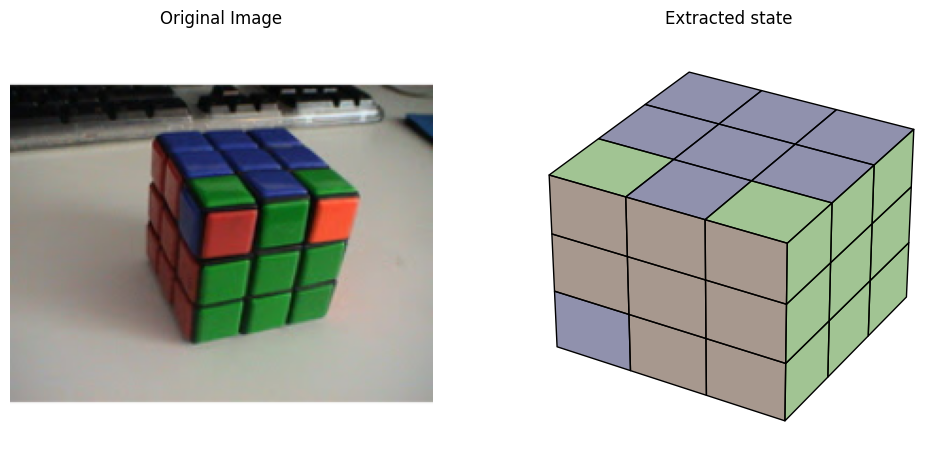

In [288]:

visualize_cube(labels, colors)